In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import json
import numpy as np
import pickle
from modules.functions import pymatgen_comp,data_generator_vec
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt
from pymoo.problems.functional import FunctionalProblem
import pymatgen.core as mg

In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

In [ ]:
def decode(vec, elem_list, thresh=0.03):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x >= thresh:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)


def wrapper_uts(val_array):
    return get_uts_without_grain(np.array(val_array).reshape(1,-1)).item()

def wrapper_w(val_array, element_list = el_list):
    w_ind = np.argwhere(np.array(element_list)=='W').item()
    return val_array[w_ind]

In [ ]:
lb = np.zeros_like(json_dict['start_comp'])
ub = np.zeros_like(json_dict['start_comp'])
for i,k in enumerate(lb):
    if el_list[i] == 'W':
        lb[i] = 0.175
    else:
        lb[i] = 0.0
for i,k in enumerate(lb):
    if el_list[i] in ['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta']:
        ub[i] = 1
    else:
        ub[i] = 0
    
ub,lb

(array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        1.]),
 array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.175]))

In [ ]:
objs = [
    
    lambda x: wrapper_w(x),
    lambda x: -wrapper_uts(x)
    
]

constr_eq = [
    lambda x: 1 - np.sum((x))
]


n_var = len(el_list)

problem = FunctionalProblem(n_var,
                            objs,
                            constr_eq = constr_eq,
                            xu=ub,
                            xl=lb
                            )

In [ ]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.sampling.lhs import LHS
from pymoo.constraints.as_obj import ConstraintsAsObjective



ref_points = np.array([wrapper_w(json_dict['start_comp']),-wrapper_uts(json_dict['start_comp'])]).reshape(1,-1)

algorithm = RNSGA2(
    ref_points=ref_points,
    pop_size=500,
    n_offsprings=50,
    sampling=LHS(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    epsilon=0.01,
    normalization='front',
    extreme_points_as_reference_points=False,
    weights=np.array([0.5, 0.5])
)


from pymoo.termination import get_termination

termination = get_termination( "n_gen",2000)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed= 1,
               save_history=True,
               verbose=True)
X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      1 |  1.1945588873 |  3.5875226229 |             - |             -
     2 |      550 |      1 |  1.0685668809 |  3.3866693848 |             - |             -
     3 |      600 |      1 |  1.0225883509 |  3.2515616140 |             - |             -
     4 |      650 |      1 |  0.4448833504 |  3.1088900823 |             - |             -
     5 |      700 |      1 |  0.4448833504 |  2.9583560785 |             - |             -
     6 |      750 |      1 |  0.4448833504 |  2.8323322112 |             - |             -
     7 |      800 |      1 |  0.4448833504 |  2.7147780817 |             - |             -
     8 |      850 |      1 |  0.4448833504 |  2.5913091284 |             - |             -
     9 |      900 |      1 |  0.4245890568 |  2.4578648971 |             - |             -
    10 |      950 |      1 |  0.4245890568 |  2.3492594046 |             - |             -

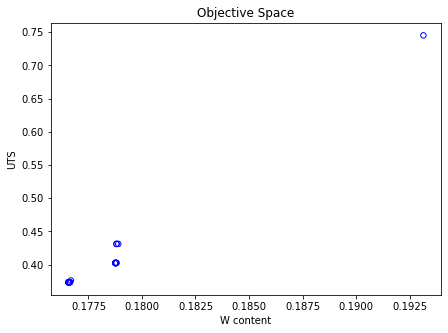

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], -1*F[:, 1], s=30, facecolors='none', edgecolors='blue')
#plt.scatter(wrapper_ft(at_frac), wrapper_uts(json_dict['start_comp']), s=30, facecolors='none', edgecolors='red')
plt.title("Objective Space")
plt.xlabel('W content')
plt.ylabel('UTS')
plt.show()

In [ ]:
optimized =[]
for f in X:
    optimized.append(decode(f, elem_list=el_list))
optimized

[Comp: Hf0.07 Zr0.12 Ti0.37 V0.03 Cr0.09 Mo0.13 W0.18,
 Comp: Hf0.2 Zr0.12 Ti0.37 V0.03 Cr0.05 Mo0.04 W0.18,
 Comp: Hf0.2 Zr0.12 Ti0.37 V0.03 Cr0.05 Mo0.04 W0.18]

In [ ]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data

In [ ]:
w_ind = np.argwhere(np.array(el_list) == 'W').item() 
w_content = vec_comps[:,w_ind]
uts = to_train_df['uts1200C'].values


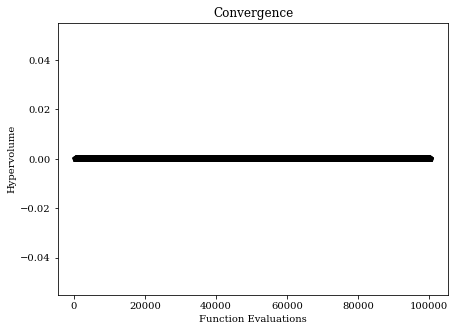

In [27]:
hist = res.history
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])


approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= ref_points.flatten(),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

## Pareto optimal solutions

In [4]:
with open('misc/starting_comp.json','r') as fid:
    start_comp_dict = json.load(fid)

start_comp = start_comp_dict['start_comp']

In [5]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data

w_ind = np.argwhere(np.array(el_list) == 'W').item() 
w_content = vec_comps[:,w_ind]
uts = to_train_df['uts1200C'].values
dist = np.array([np.linalg.norm(x - start_comp) for x in vec_comps]).reshape(-1,1)


costs = np.hstack((w_content.reshape(-1,1),-1*uts.reshape(-1,1), dist ))

def is_pareto_efficient(costs, return_mask = True):
    """    Find the pareto-efficient points    :param costs: An (n_points, n_costs) array    :param return_mask: True to return a mask    :return: An array of indices of pareto-efficient points.        If return_mask is True, this will be an (n_points, ) boolean array        Otherwise it will be a (n_efficient_points, ) integer array of indices.    """    
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for    
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True        
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points        
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1    
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True        
        return is_efficient_mask    
    else:
        return is_efficient